In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer   #Learned how to use these things from: https://scikit-learn.org/stable/modules/feature_extraction.html
import string
import re
import nltk
import matplotlib.pyplot as plt

In [2]:
def stem_string(string):
    return " ".join([nltk.PorterStemmer().stem(i) for i in string.split()])

In [3]:
def load_data_for_clf():
    #Loads data and returns it as a labelled DataFrame
    
    df_1950=pd.read_csv("./Data/1950s.csv").drop(columns=["Unnamed: 0"])
    df_1950["Decade"]="50s"
    
    df_1960=pd.read_csv("./Data/1960s.csv").drop(columns=["Unnamed: 0"])
    df_1960["Decade"]="60s"
    
    df_1970=pd.read_csv("./Data/1970s.csv").drop(columns=["Unnamed: 0"])
    df_1970["Decade"]="70s"
    
    df_1980=pd.read_csv("./Data/1980s.csv").drop(columns=["Unnamed: 0"])
    df_1980["Decade"]="80s"
    
    df_1990=pd.read_csv("./Data/1990s.csv").drop(columns=["Unnamed: 0"])
    df_1990["Decade"]="90s"
    
    df_2000=pd.read_csv("./Data/2000s.csv").drop(columns=["Unnamed: 0"])
    df_2000["Decade"]="00s"
    
    df_2010=pd.read_csv("./Data/2010s.csv").drop(columns=["Unnamed: 0"])
    df_2010["Decade"]="10s"
    
    df_all=pd.concat([df_1950, df_1960, df_1970,df_1980, df_1990, df_2000, df_2010]).reset_index()
    
    
    return df_all

In [4]:
def get_multinomial_params(df_all, num_unique_words, tfidf=True, stem=True):
    """Inputs: 
    df_all: The output of load_data_for_clf()
    num_unique_words: How many words should be used in the analysis. The function picks out the top num_unique_words words 
    (based on total frequency) to use in the classifier. 
    tfidf: Whether or not tfidf transformation should be used. If not, simple TDM (word counts) will be used.
    
    Output:
    DataFrame of multinomial logit parameters"""
    
    df_all["lyrics"]=df_all["lyrics"].apply(lambda x: re.sub(r'\[.*\]', '', x))  # Stripping [Intro] etc
    df_all["lyrics"]=df_all["lyrics"].apply(lambda x: re.sub(r'\n+', '\n', x))   # Stripping newlines
    df_all["lyrics"]=df_all["lyrics"].apply(lambda x: x.lower())  # Folding case
    df_all["lyrics"]=df_all["lyrics"].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))  # Stripping punctuation
    
    #Transform text to tfidf or word counts
    if tfidf:
        transformer=TfidfVectorizer(max_features=num_unique_words)
    else:
        transformer=CountVectorizer(max_features=num_unique_words)
        
    if stem:
        df_all["lyrics"]=df_all["lyrics"].apply(stem_string)

    X=pd.DataFrame(transformer.fit_transform(df_all["lyrics"]).todense())
    
    #Extract the class label
    y=df_all["Decade"]

    #Create and train the model. 
    #The name is LogisticRegression, but this is actually an unordered multinomial logit model as taught by Ole.
    #An unordered multinomial logit is implemented in Python as the LogisticRegression when there are more than 2 classes.
    clf=LogisticRegression(max_iter=1000, multi_class="multinomial")
    clf.fit(X, y)

    #Extract the terms/words that the tfidf/word counts are associated with
    vocab={x: y for (y, x) in transformer.vocabulary_.items()}
    ordered_words=[vocab[i] for i in range(0, num_unique_words)]
    
    #Extract the (beta) parameters from the multinomial logit model
    lr_weights=pd.DataFrame(clf.coef_)
    lr_weights.columns=ordered_words
    lr_weights.index=clf.classes_
    
    print(clf.score(X, y))  #Print accuracy
    
    #Return the results
    return lr_weights.transpose()[["50s", "60s", "70s", "80s", "90s", "00s", "10s"]]

In [5]:
get_multinomial_params(load_data_for_clf(), 500, True, True).to_csv("results_500_words_tfidf_stemmed.csv")

0.5169613857813063


In [6]:
get_multinomial_params(load_data_for_clf(), 500, False, True).to_csv("results_500_words_bow_stemmed.csv")

0.6008661133164922


C:\Users\andre\.conda\envs\BothPythonR\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [7]:
len(load_data_for_clf())

5542

In [8]:
results=pd.read_csv("results_500_words_bow_stemmed.csv")

In [9]:
results.columns=['word', '50s', '60s', '70s', '80s', '90s', '00s', '10s']

In [10]:
def plot_results(results_df, word):
    plt.bar(range(7), results[results["word"]==word].drop(columns=["word"]).values[0], color='#41ADBC')
    plt.xticks(range(7), ["1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s"])
    plt.xlabel("Decade")
    plt.ylabel("Coefficient estimate")
    if word=="shit":
        word="s**t"
    plt.title("Classifier results for '"+word+"'")
    plt.show()

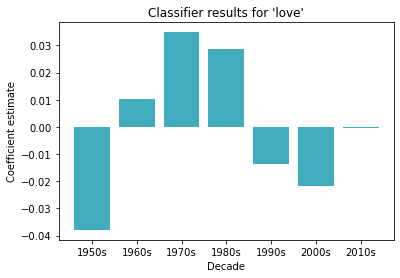

In [11]:
plot_results(results, "love")

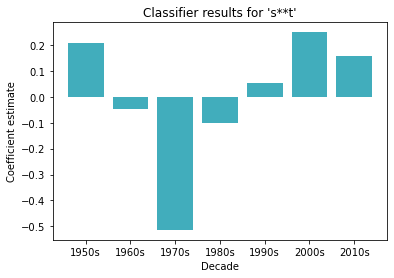

In [12]:
plot_results(results, "shit")

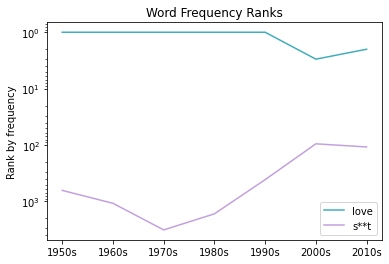

In [13]:
plt.plot([1,1,1,1,1,3,2], color='#41ADBC')
plt.plot([636, 1077, 3191, 1654, 410, 95,108], color="#C2A0DE")
plt.legend(["love", "s**t"])
plt.yscale("log")
plt.ylabel("Rank by frequency")
plt.title("Word Frequency Ranks")
plt.xticks(range(7), ["1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s"])
plt.gca().invert_yaxis()
plt.show()